# Get a LSST Simulated Cadence for Arbitrary Sky Position
___


___

In [1]:
"""

"""
%matplotlib inline
# %matplotlib notebook

from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import os
import sys
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table

import lsst_tools.utils as utils 
import lsst_tools.utils.colours as colours 

import pyCoCo as pccsims
import pycoco as pcc

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [2]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
opsimdbpath = os.environ.get('OPSIMDBPATH')
print(opsimdbpath)
# opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

/Users/berto/data/LSST/OpSimOutputDBs/minion_1016_sqlite.db


Check that the db looks as we expect

In [41]:
opsimdf.head()

KeyError: 'fieldID == 2786'

Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [4]:
working_df = opsimdf

In [5]:
working_df = utils.find_MW_extinction(working_df)

## Choosing Position and Identifying Fields
___

Use **`lsst_tools.utils.generate_coordinates()`** to give us a position 


In [50]:
working_df.query("fieldID == 2786").columns

Index(['obsHistID', 'sessionID', 'propID', 'fieldID', 'fieldRA', 'fieldDec',
       'filter', 'expDate', 'expMJD', 'night', 'visitTime', 'visitExpTime',
       'finRank', 'FWHMeff', 'FWHMgeom', 'transparency', 'airmass',
       'vSkyBright', 'filtSkyBrightness', 'rotSkyPos', 'rotTelPos', 'lst',
       'altitude', 'azimuth', 'dist2Moon', 'solarElong', 'moonRA', 'moonDec',
       'moonAlt', 'moonAZ', 'moonPhase', 'sunAlt', 'sunAz', 'phaseAngle',
       'rScatter', 'mieScatter', 'moonIllum', 'moonBright', 'darkBright',
       'rawSeeing', 'wind', 'humidity', 'slewDist', 'slewTime',
       'fiveSigmaDepth', 'ditheredRA', 'ditheredDec', 'EBV_MW'],
      dtype='object')

In [45]:
#%%timeit ## The slowest run took 39.04 times longer than the fastest. This could mean that an intermediate result is being cached.
#         ## 1000 loops, best of 3: 246 µs per loop
n = 1
pos_df = utils.generate_coordinates(n)
print(pos_df)
# pos_df["phi"] = -0.122
# pos_df["phi"] = 2.616673 DDF
# pos_df["theta"] = 0.0
# pos_df["theta"] = 0.023055 DDF

        phi     theta        RA       Dec
0 -0.790012  1.924116  5.065708 -0.790012


Check the positions are sensible

/Users/berto/Code/LSST_tools/lsst_tools


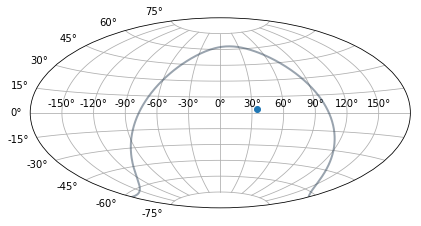

In [7]:
#%%timeit ## 1 loop, best of 3: 235 ms per loop
utils.plot_position_points(pos_df)

We want to find out which field(s) the position is in. Create table that tells us the field centres, and find the edges.

In [46]:
# working_df = utils.get_field_corners(working_df.drop_duplicates("fieldID"))[['fieldRA', 'fieldDec']]
allfields_df = utils.get_field_corners(pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec']])

In [47]:
allfields_df.head()

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
0,316,1.676483,-1.082473,1.707026,1.645940,-1.113016,-1.051930
1,372,1.694120,-1.033972,1.724663,1.663577,-1.064515,-1.003429
2,441,1.708513,-0.985271,1.739056,1.677970,-1.015814,-0.954728
3,505,1.720374,-0.936476,1.750917,1.689831,-0.967019,-0.905933
4,587,1.730248,-0.887672,1.760791,1.699705,-0.918215,-0.857129


In [48]:
field_df = allfields_df[(allfields_df["RA_upper"] >= pos_df["theta"][0] + np.pi) &
                (allfields_df["RA_lower"] <= pos_df["theta"][0] + np.pi) &
                (allfields_df["Dec_lower"] >= pos_df["phi"][0])  &
                (allfields_df["Dec_upper"] <= pos_df["phi"][0])]

This narrows down the fields in which our position appears:

In [49]:
field_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower


### Deep Drilling Fields:
___

* minion2016: 1427,744,2412,290,2786
* astro_lsst_01_1068: 1427,744,2412,290,2786
* Fake_Rolling: 290,2786


In [12]:
opsimdf.loc[opsimdf["fieldID"] == 505].head() ## WFD

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec,EBV_MW
3,4,1016,54,505,1.720374,-0.936476,y,3038,59580.035169,0,...,104.669398,0.920473,0.0,0.0,0.049266,4.605366,21.032718,1.694604,-0.962927,0.073125
736,737,1016,54,505,1.720374,-0.936476,z,89952,59581.041121,1,...,102.261170,0.701202,0.0,0.0,0.053899,4.752482,21.760884,1.701047,-0.962927,0.073125
760,761,1016,54,505,1.720374,-0.936476,z,90898,59581.052066,1,...,99.499712,0.729082,0.0,0.0,0.087567,6.236553,21.759073,1.701047,-0.962927,0.073125
1482,1483,1016,54,505,1.720374,-0.936476,z,176788,59582.046159,2,...,100.267993,0.826179,0.0,0.0,0.053899,4.727801,21.650976,1.707489,-0.962927,0.073125
15455,15455,1016,54,505,1.720374,-0.936476,r,1820874,59601.074933,21,...,87.151631,0.741071,0.0,0.0,0.049177,5.204940,23.957933,1.701047,-0.956314,0.073125


In [13]:
opsimdf.loc[opsimdf["fieldID"] == 1427].head() ## DDF

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec,EBV_MW
229,230,1016,56,1427,0.925184,-0.4789,r,12057,59580.139555,0,...,84.646287,0.866285,0.0,0.0,0.755889,140.0,24.070428,0.907976,-0.505351,0.007715
230,231,1016,56,1427,0.925184,-0.4789,r,12093,59580.139972,0,...,84.969264,0.791241,0.0,0.0,0.000000,2.0,24.143180,0.907976,-0.505351,0.007715
231,232,1016,56,1427,0.925184,-0.4789,r,12129,59580.140389,0,...,85.037385,0.791241,0.0,0.0,0.000000,2.0,24.141983,0.907976,-0.505351,0.007715
232,233,1016,56,1427,0.925184,-0.4789,r,12165,59580.140805,0,...,85.105955,0.859965,0.0,0.0,0.000000,2.0,24.068792,0.907976,-0.505351,0.007715
233,234,1016,56,1427,0.925184,-0.4789,r,12201,59580.141222,0,...,85.174974,0.859965,0.0,0.0,0.000000,2.0,24.067582,0.907976,-0.505351,0.007715


In [14]:
# reload(pccsims)

## Extinction

Get the Milky Way extinction along the line of site towards the SNe. The working_df contains the EBV_MW at the field centre, but we can do better than that, by using the position of the SN itself.

In [15]:
working_df["EBV_MW"][working_df["fieldID"].isin(working_df["fieldID"].values)].values

array([ 0.04527743,  0.04593042,  0.08043004, ...,  0.05865358,
        0.06319557,  0.05767386])

In [16]:
pos_df

,phi,theta,RA,Dec
0,0.064899,0.611528,3.753121,0.064899


In [17]:
# %%timeit ## 1 loop, best of 3: 88.6 ms per loop
pos_df = utils.find_MW_extinction(pos_df) 

extinction = pos_df["EBV_MW"].values[0]
print(extinction)

0.0356292696034


In [18]:
# filter_path = "/Users/berto/Code/CoCo/data/filters"
filter_path = pcc._default_filter_dir_path
# coco_root_path = "/Users/berto/Code/CoCo"
coco_root_path = pcc._default_coco_dir_path 

coco = pccsims.pyCoCo(utils.b(filter_path), utils.b(coco_root_path))

inputs:

* **`snname`**
* **`redshift`**
* **`absmag offset`**
* **`EBV MW`**
* **`EBV Host`**
* **`Rv`**
* **`MJD at Peak`**

* **`MJD to simulate`**
* **`filters to simulate`**

In [52]:
z_obs = 0.007
# z_obs = 0.1
# z_obs = 0.2
# host_EBV = 0.2
host_EBV = 0.0
# MW_EBV = extinction
MW_EBV = 0.0
# mjdmax = 60307.314753999999
# mjdmax = 59580 + 1.* 365. ## DDF 2786
# mjdmax = 59580 + 1.5* 365. ## WFD 550
mjdmax = 59580 + 1.3* 365. ## WFD 2297

field_df = pd.DataFrame({"fieldID" : [2786]})

In [53]:
mjd_to_sim = working_df["expMJD"][working_df["fieldID"].isin(field_df["fieldID"].values)].values
limiting_mags = working_df["fiveSigmaDepth"][working_df["fieldID"].isin(field_df["fieldID"].values)].values

filters_to_sim = working_df["filter"][working_df["fieldID"].isin(field_df["fieldID"].values)].values
filters_to_sim = np.array([utils.b('LSST_'+x) for x in filters_to_sim])

In [54]:
# mjd_to_sim = np.array([90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 105.0, 110.0, 115.0, 120.0])
# filters_to_sim = np.array([b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r'])
# mjd_to_sim = 
# filters_to_sim = 

print(mjdmax)
print(mjd_to_sim)
print(filters_to_sim)

60054.5
[ 59582.171539  59582.324188  59582.324605 ...,  63004.982844  63004.983261
  63004.983678]
[b'LSST_z' b'LSST_u' b'LSST_u' ..., b'LSST_u' b'LSST_u' b'LSST_u']


In [55]:
# plt.scatter(mjd_to_sim, np.ones(len(mjd_to_sim)))
# plt.scatter([mjdmax], [1])

In [56]:
# filters_to_sim = np.array([i.replace(utils.b("LSST"), utils.b("SDSS")) for i in filters_to_sim])

In [57]:
# flux, flux_err = coco.simulate(b"SN2007uy", 
#                     z_obs, 0.0, MW_EBV, host_EBV, 3.1, 
#                     mjdmax, mjd_to_sim, 
#                     filters_to_sim)
snname = b"SN2007uy"
# snname = b"SN2009jf"
flux, flux_err = coco.simulate(snname, 
                    z_obs, 0.0, MW_EBV, host_EBV, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)
# flux, flux_err = coco.simulate(b"SN2009jf", 
#                     z_obs, 0.0, 0.1, 0.1, 3.1, 
#                     mjdmax, mjd_to_sim, 
#                     filters_to_sim)

In [58]:
flux, flux_err

(array([             nan,   3.54488649e-31,   3.54500796e-31, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))

In [59]:
print(np.nanmax(flux))

1.92062674778e-15


In [27]:
# reload(pcc.classes)

<module 'pycoco.classes' from '/Users/berto/Code/verbose-enigma/pycoco/classes.py'>

In [60]:
p = pcc.PhotometryClass()
phot_table = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim)
phot_table = phot_table[np.where(phot_table["flux"] > 1e-20)]
p.load_table(phot_table)

/Users/berto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


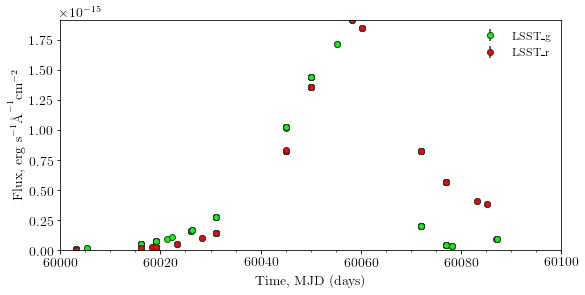

In [65]:
p.plot(["LSST_g", "LSST_r"], xlim = [60000, 60100])

In [69]:
p.save(filename = "LSST_DDF_2786_cadence.dat", path = "/Users/berto/projects/LSST/cadence/")

has data
/Users/berto/projects/LSST/cadence/LSST_DDF_2786_cadence.dat
Writing /Users/berto/projects/LSST/cadence/LSST_DDF_2786_cadence.dat


In [ ]:
t = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim)

In [ ]:
t[np.logical_and(t["filter"] != "SDSS_y", t["filter"]!= "SDSS_z")]

In [ ]:
p = pcc.PhotometryClass()
pt = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim)
pt_lim_m = pt
pt_lim_m["fivesigmadepth"] = limiting_mags

In [ ]:
pt = pt_lim_m[np.where(pt_lim_m["flux"] > 1e-22)]

In [ ]:
pt

In [ ]:
days_before = 40
days_after = 100
print(mjdmax)
w = np.where(np.logical_and(pt["MJD"] > mjdmax - days_before, pt["MJD"] < mjdmax + days_after))
print(w)
pt[w]

In [ ]:
print(snname)
print(chosenfield)
print(z_obs)
print(extinction)
print(opsimdbpath)
print(mjdmax)

In [ ]:
reload(pcc)
reload(pcc.classes)
# reload(pcc.utils)

In [ ]:
p.load_table(pt[w], verbose= True)

p.plot()

In [ ]:
p.unpack(verbose = True)

In [ ]:
phot_table = p.phot.loc["filter", "LSST_u"]

In [ ]:
phot_table

In [ ]:
phot_table.meta["filter_filename"] = "foo"

In [ ]:
pt[w]

In [ ]:
# filter_file_type = '.dat'
# filter_names = np.unique(pt[w]["filter"])
# print(filter_names)
# pt.add_index('filter', unique = True)
# for filter_name in filter_names:
# #     phot_table = self.phot.loc["filter", filter_name]
#     filter_filename = filter_name + filter_file_type
#     print(filter_filename)

In [ ]:
# reload(pcc)
# phot = pcc.PhotometryClass()
# infile = "/Users/berto/projects/LSST/cadence/lightcurves/SNSim_0002_minion_1016_SN2007uy_z=02_EBVMW=0029_EBVHOST=01_fieldID=2297WFD.dat"
# phot.load(path = infile, names = ("MJD", "flux", "flux_err", "filter", "fivesigmadepth"), verbose = True)
# # phot.load_phot_from_file(path = infile, format = "ascii.commented_header")

# phot.unpack(verbose = True)

In [ ]:
# phot.data

In [ ]:
# phot_table = Table.read(infile, names = ("MJD", "flux", "flux_err", "filter", "fivesigmadepth"), format = "ascii")

In [ ]:
# phot_table.meta["filename"] = infile

# phot_table["MJD"].unit = u.day
# phot_table["flux"].unit = u.cgs.erg / u.si.angstrom / u.si.cm ** 2 / u.si.s
# phot_table["flux_err"].unit =  phot_table["flux"].unit

In [ ]:
# reload(pcc)
# p = pcc.PhotometryClass()
# p.load_table(phot_table, verbose = True)